In [ ]:
from math import sqrt
from numpy import concatenate
import tensorflow as tf
from matplotlib import pyplot
from pandas import read_csv
from tensorflow import keras 
from pandas import DataFrame
from pandas import concat
from tensorflow.keras.optimizers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
dataset = read_csv('/content/station.csv')
#dataset=dataset.drop(['day','month','mintemp','Bias'],axis=1)
values = dataset.values
values.shape

# dataset.head(30)

(881, 3)

In [ ]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [ ]:
# specify the number of lag hours
n_days = 7 
n_features =13
# frame as supervised learning
reframed = series_to_supervised(scaled, n_days, 1) 
# reframed
print(reframed.head())

In [ ]:
reframed.head()

,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
7,0.723906,0.286184,0.0,0.754209,0.294988,0.0,0.774411,0.336107,0.0,0.794613,...,0.0,0.784512,0.328851,0.0,0.713805,0.299149,0.0,0.622896,0.189629,0.0
8,0.754209,0.294988,0.0,0.774411,0.336107,0.0,0.794613,0.347814,0.0,0.734007,...,0.0,0.713805,0.299149,0.0,0.622896,0.189629,0.0,0.622896,0.205882,0.0
9,0.774411,0.336107,0.0,0.794613,0.347814,0.0,0.734007,0.359036,0.0,0.784512,...,0.0,0.622896,0.189629,0.0,0.622896,0.205882,0.0,0.622896,0.166022,0.0
10,0.794613,0.347814,0.0,0.734007,0.359036,0.0,0.784512,0.328851,0.0,0.713805,...,0.0,0.622896,0.205882,0.0,0.622896,0.166022,0.0,0.693603,0.159540,0.0
11,0.734007,0.359036,0.0,0.784512,0.328851,0.0,0.713805,0.299149,0.0,0.622896,...,0.0,0.622896,0.166022,0.0,0.693603,0.159540,0.0,0.663300,0.183727,0.0


In [ ]:
values = reframed.values 
values
n_train_days = 8251
train = values[:n_train_days, :] 

val = values[n_train_days:1028+n_train_days, :]  

test=values[1028+n_train_days:,:]
# test

In [ ]:
n_obs = n_days* n_features
print(n_obs)

21


In [ ]:
train_X, train_y = train[:, :n_obs], train[:, -n_features]
# print(train_X[-1,:])
# print(train_y[-1])
val_X, val_y = val[:, :n_obs], val[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]  
# print(test_X[0,:])
# print(test_y[0])


# print(val_X)

In [ ]:
print(train_X.shape, len(train_X), train_y.shape)

(612, 21) 612 (612,)


In [ ]:
# train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
# val_X = val_X.reshape((val_X.shape[0],n_days,n_features))
# test_X = test_X.reshape((test_X.shape[0], n_days, n_features))


# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape,val_X.shape)
# val_X.shape
# print(val_X[0,:])

In [ ]:
from keras.callbacks import EarlyStopping
import numpy as np 

epochs = 800
batch =32
lr = 0.0003
adam =Adam(lr) 

In [ ]:

def test_diff_strategies(units,loss_tmp,optmzr,val_X,val_y,test_X,test_y):

  model_mlp = Sequential()
  model_mlp.add(Dense(units, activation='relu', input_dim=21))
  model_mlp.add(Dense(1))
  model_mlp.compile(loss=loss_tmp, optimizer=optmzr)
  es=EarlyStopping(monitor='val_loss',patience=30,verbose =1)
  mlp_history = model_mlp.fit(train_X, train_y,callbacks=es,validation_data=(val_X,val_y), epochs=epochs, verbose=2)

  pyplot.plot(mlp_history.history['loss'], label='train')
  pyplot.plot(mlp_history.history['val_loss'], label='val')
  pyplot.legend() 
  pyplot.show() 
  
  yhat = model_mlp.predict(val_X) 
  fcp1=np.repeat(yhat,3,axis=1)
  inv_yhat=scaler.inverse_transform(fcp1)
  inv_yhat = inv_yhat[:,0]


  val_y = val_y.reshape((len(val_y), 1))
  fcp2=np.repeat(val_y,3,axis=1)
  inv_y = scaler.inverse_transform(fcp2) 
  inv_y = inv_y[:,0] 
  

  validation_rmse = sqrt(mean_squared_error(inv_y, inv_yhat))  

  yhat_test = model_mlp.predict(test_X)
  fcp3=np.repeat(yhat_test,3,axis=1)
  inv_yhat_test = scaler.inverse_transform(fcp3) 
  inv_yhat_test = inv_yhat_test[:,0]
  inv_yhat_test.reshape(inv_yhat_test.shape[0],1)
  test_y = test_y.reshape((len(test_y), 1))
  fcp4=np.repeat(test_y,3,axis=1)
  inv_testy = scaler.inverse_transform(fcp4) 
  inv_testy = inv_testy[:,0]
  inv_testy.reshape(inv_testy.shape[0],1) 

  test_rmse=sqrt(mean_squared_error(inv_testy, inv_yhat_test))

  # yhat_test = model_mlp.predict(test_X)
  # print('val rmse:', validation_rmse)
  # print('Test rmse:',test_rmse) 
  dict_of_values={'units':units,'optimizer':optmzr,'Loss':loss_tmp,'ValRMSE':validation_rmse,'TestRMSE':test_rmse} 
  return (dict_of_values,model_mlp,mlp_history) 


Epoch 1/800
20/20 - 1s - loss: 0.4944 - val_loss: 0.0823 - 701ms/epoch - 35ms/step
Epoch 2/800
20/20 - 0s - loss: 0.1174 - val_loss: 0.0279 - 65ms/epoch - 3ms/step
Epoch 3/800
20/20 - 0s - loss: 0.0373 - val_loss: 0.0346 - 55ms/epoch - 3ms/step
Epoch 4/800
20/20 - 0s - loss: 0.0250 - val_loss: 0.0202 - 71ms/epoch - 4ms/step
Epoch 5/800
20/20 - 0s - loss: 0.0167 - val_loss: 0.0123 - 81ms/epoch - 4ms/step
Epoch 6/800
20/20 - 0s - loss: 0.0115 - val_loss: 0.0063 - 71ms/epoch - 4ms/step
Epoch 7/800
20/20 - 0s - loss: 0.0080 - val_loss: 0.0046 - 56ms/epoch - 3ms/step
Epoch 8/800
20/20 - 0s - loss: 0.0065 - val_loss: 0.0040 - 62ms/epoch - 3ms/step
Epoch 9/800
20/20 - 0s - loss: 0.0056 - val_loss: 0.0037 - 70ms/epoch - 4ms/step
Epoch 10/800
20/20 - 0s - loss: 0.0054 - val_loss: 0.0035 - 64ms/epoch - 3ms/step
Epoch 11/800
20/20 - 0s - loss: 0.0048 - val_loss: 0.0035 - 55ms/epoch - 3ms/step
Epoch 12/800
20/20 - 0s - loss: 0.0046 - val_loss: 0.0035 - 54ms/epoch - 3ms/step
Epoch 13/800
20/20 - 0s

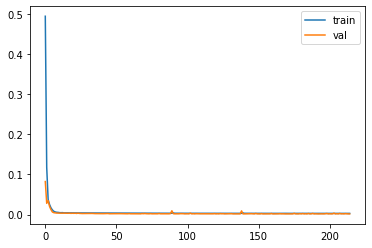

In [ ]:
# from keras.optimizers import Adam,adagrad_v2,SGD,RMSprop,Adadelta,Adagrad,Adamax,Nadam,Ftrl
import tensorflow as tf
from tensorflow.keras.optimizers import * 
from tensorflow.keras.losses import *
list_of_results=[]
#list_of_units = [6,7,90,30,128] 

list_of_units=[128] 

#list_of_losses = [MeanSquaredLogarithmicError(),Huber(),LogCosh(),'mae','mse']

list_of_losses=['mse'] 
lr= 0.0003
#list_of_optmzrs=[ Adam(lr),SGD(lr),RMSprop(lr),Adadelta(lr),Adagrad(lr),Adamax(lr),Nadam(lr),Ftrl(lr)] 
# lr= 0.0003
list_of_optmzrs=[Nadam(lr)]
for unit in list_of_units:
  for loss in list_of_losses:
    for op in list_of_optmzrs: 
      dict_to_be_stored,model,his=test_diff_strategies(unit,loss,op,val_X,val_y,test_X,test_y) 
      list_of_results.append(dict_to_be_stored)

In [ ]:
final_list= [] 
list_of_ops=[] 
list_of_units=[] 
list_of_loss=[] 
vali_list=[] 
test_list=[] 
# 'units':units,'optimizer':optmzr,'Loss':loss_tmp,'ValRMSE':validation_rmse,'TestRMSE':test_rmse

for result in list_of_results:
  list_of_units.append(result['units']) 
  list_of_ops.append(result['optimizer']) 
  list_of_loss.append(result['Loss']) 
  vali_list.append(result['ValRMSE']) 
  test_list.append(result['TestRMSE']) 
# final_list.append(list_of_ops)
# final_list.append(list_of_ops)
final_list=[list_of_units,list_of_ops,list_of_loss,vali_list,test_list]  
final_list

[[128],
 ['mse'],
 [1.1789686526498357],
 [1.0972940519350538]]

In [ ]:
import pandas as pd 
df = pd.DataFrame(final_list).T 
df.to_csv('min_temp_finalresults_mlp.csv')

In [ ]:
import numpy as np 

yhat = model.predict(val_X) 
fcp1=np.repeat(yhat,13,axis=1)
inv_yhat=scaler.inverse_transform(fcp1)
inv_yhat = inv_yhat[:,0]


val_y = val_y.reshape((len(val_y), 1))
fcp2=np.repeat(val_y,13,axis=1)
inv_y = scaler.inverse_transform(fcp2) 
inv_y = inv_y[:,0]

validation_rmse = sqrt(mean_squared_error(inv_y, inv_yhat))  

yhat_test = model.predict(test_X)
fcp3=np.repeat(yhat_test,13,axis=1)
inv_yhat_test = scaler.inverse_transform(fcp3) 
inv_yhat_test = inv_yhat_test[:,0]
inv_yhat_test.reshape(inv_yhat_test.shape[0],1)
test_y = test_y.reshape((len(test_y), 1))
fcp4=np.repeat(test_y,13,axis=1)
inv_testy = scaler.inverse_transform(fcp4) 
inv_testy = inv_testy[:,0]
inv_testy.reshape(inv_testy.shape[0],1) 

test_rmse=sqrt(mean_squared_error(inv_testy, inv_yhat_test))

# yhat_test = model_mlp.predict(test_X)
print('val rmse:', validation_rmse)
print('Test rmse:',test_rmse)

val rmse: 1.1789686526498357
Test rmse: 1.0972940519350538


In [ ]:
import pickle 
#loaded_model_7_adam_msl = pickle.load(open('/lstm_7_adam_msl_with_month', 'rb'))  
# # import pickle 
with open('mlpmin_u90_adam_612','wb') as f: 
  pickle.dump(model,f)